### Cleaning the Data

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np


In [3]:
df = pd.read_csv('data/bankloan.csv')

In [4]:
# Drop ID and ZipCode (not useful for prediction)
df.drop(['ID', 'ZIP.Code'], axis=1, inplace=True)

In [5]:
# Features and Target
X = df.drop('Personal.Loan', axis=1)
y = df['Personal.Loan']

In [6]:
# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Save the fitted scaler - to use for streamlit UI
import joblib
joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']

In [8]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
print("Data is ready.")
print("X_train shape:", X_train.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))

Data is ready.
X_train shape: (4000, 11)
y_train distribution:
 Personal.Loan
0    0.904
1    0.096
Name: proportion, dtype: float64


### Building Model with Keras

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [11]:
# Class weight works only with numpy arrays
y_train = y_train.to_numpy()


In [12]:
# Compute class weights to handle imbalance
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# Properly map weights to actual class labels
class_weight_dict = dict(zip(classes, class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: 0.5530973451327433, 1: 5.208333333333333}


In [ ]:
# Build the model with dropout to prevent overfitting
model = Sequential([
    Input(shape=(X_train.shape[1],)), 
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [14]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

In [15]:
# Define callbacks for early stopping, model checkpointing and logging

# Callbacks
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("bankloan_model.keras", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir="./logs/loan_model")

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [16]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4288 - auc: 0.7382 - loss: 0.6427 - val_accuracy: 0.8537 - val_auc: 0.9451 - val_loss: 0.3723
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8551 - auc: 0.9319 - loss: 0.3504 - val_accuracy: 0.8763 - val_auc: 0.9639 - val_loss: 0.2796
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8721 - auc: 0.9594 - loss: 0.2775 - val_accuracy: 0.9075 - val_auc: 0.9712 - val_loss: 0.2108
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9077 - auc: 0.9692 - loss: 0.2238 - val_accuracy: 0.9000 - val_auc: 0.9741 - val_loss: 0.2242
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8876 - auc: 0.9645 - loss: 0.2170 - val_accuracy: 0.9100 - val_auc: 0.9756 - val_loss: 0.2082
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9081 - auc: 0.9744 - loss: 0.2109 - val_accuracy: 0.9200 - val_auc: 0.9786 - val_loss: 0.1800
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 

### Evaluating the Model

In [17]:
loss, accuracy, auc = model.evaluate(X_test, y_test.to_numpy(), verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")


Test Loss: 0.1086
Test Accuracy: 0.9570
Test AUC: 0.9940


In [18]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [19]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       904
           1       0.70      0.97      0.81        96

    accuracy                           0.96      1000
   macro avg       0.85      0.96      0.89      1000
weighted avg       0.97      0.96      0.96      1000

[[864  40]
 [  3  93]]


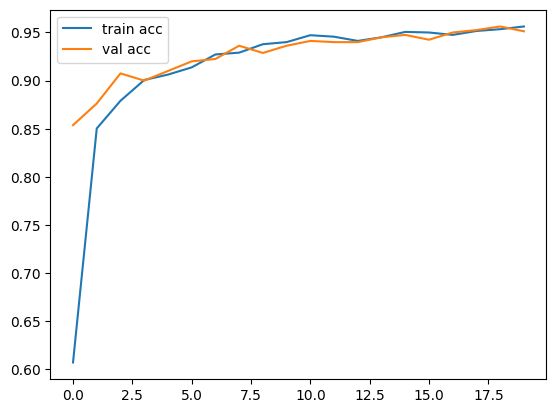

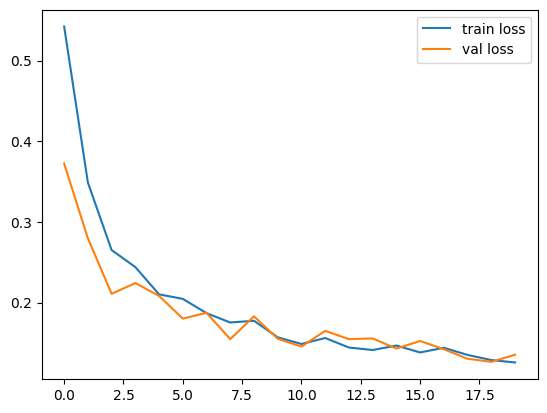

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()


### Saving Model

In [20]:
model.save("bankloan_model.keras") 